In [ ]:
from google.colab import drive    
 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python==3.4.2.16

!pip install opencv-contrib-python==3.4.2.16


     |████████████████████████████████| 25.0MB 1.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 160kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt



In [100]:
path_traindis='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Disguise/'
path_traingen='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Genuine/'
path_trainref='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Reference/'
path_trainsim='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TrainingSet/Simulated/'
path_testque= '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TestSet/Questioned/'
path_testref= '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/TestSet/Reference/'

In [101]:
def convert_to_pkl (dat,filename):
    dbfile=open(filename,'wb')
    pickle.dump(dat,dbfile)
    dbfile.close()
    dbfile=open(filename,'rb')
    return pickle.load(dbfile)

def Local_Stable_features(path,feat):

    # Perform SURF for each Reference Image

    images = os.listdir(path)
    images=sorted(images)
    print(images)
    Key_des = []
    Key_points= []
    if feat=='surf':
      surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 1000, extended = 1)
    elif feat=='sift':
      surf = cv2.xfeatures2d.SIFT_create()
    elif feat=='ORB':
      surf = cv2.ORB_create(nfeatures=500)
    img=np.array([cv2.imread(path+me,0) for me in images if (me[len(me)-4:len(me)]==".png" or me[len(me)-4:len(me)]==".PNG" or me[len(me)-5:len(me)]==".jpeg")])
    n=img.shape[0]
    Key_points=np.array([surf.detectAndCompute(img[i], None)[0] for i in range(n)])
    Key_des=np.array([surf.detectAndCompute(img[i], None)[1] for i in range(n)])

    # Find stable keypoints
    Stable_des   = []
    st_pnt = []
    unst_pnt = []
    for i in range(Key_des.shape[0]):
        indexes = list(range(Key_des.shape[0]))                                # Generate LOO database
        indexes.pop(i)
        tmp_db = np.concatenate(Key_des[indexes])

        total_dist = 0                                                         # Find minimum distance for each keypoint
        distances = []
        for keypoint in Key_des[i]:
            min_dist = np.min(np.linalg.norm(tmp_db - keypoint, axis=1))       # distance from the respective keypoint from its matched point
            total_dist += min_dist
            distances.append(min_dist)
        avg_dist = total_dist / Key_des[i].shape[0]

        st_ind = np.where(distances <= avg_dist)[0]                               # Append keypoints less than average distance
        st_pnt.append([Key_points[i][j] for j in st_ind])

        unst_ind = np.where(distances > avg_dist)[0]
        unst_pnt.append([Key_points[i][j] for j in unst_ind])

        Stable_des.extend(list(Key_des[i][np.where(distances <= avg_dist)]))

    Stable_des = np.stack(Stable_des)
    plt.figure(figsize = (50, 50), dpi = 60)
    for i in range(img.shape[0]):
       
        
        tmp1 = cv2.drawKeypoints(img[i],unst_pnt[i],None,color = (255,0,0))
        tmp2 = cv2.drawKeypoints(img[i],st_pnt[i],None,color = (0,255,0))
        plt.subplot(img.shape[0],2,2*i+1)

        plt.imshow(tmp2)
        plt.axis('off')
        plt.title('Stable Keypoints')

        plt.subplot(img.shape[0],2,2*i+2)
        plt.imshow(tmp1)
        plt.axis('off')
        plt.title('Unstable Keypoints')

    plt.show()
    return Stable_des

['R001.png', 'R002.png', 'R003.png', 'R004.png', 'R005.png', 'R006.png', 'R007.PNG', 'R008.png', 'R009.png']


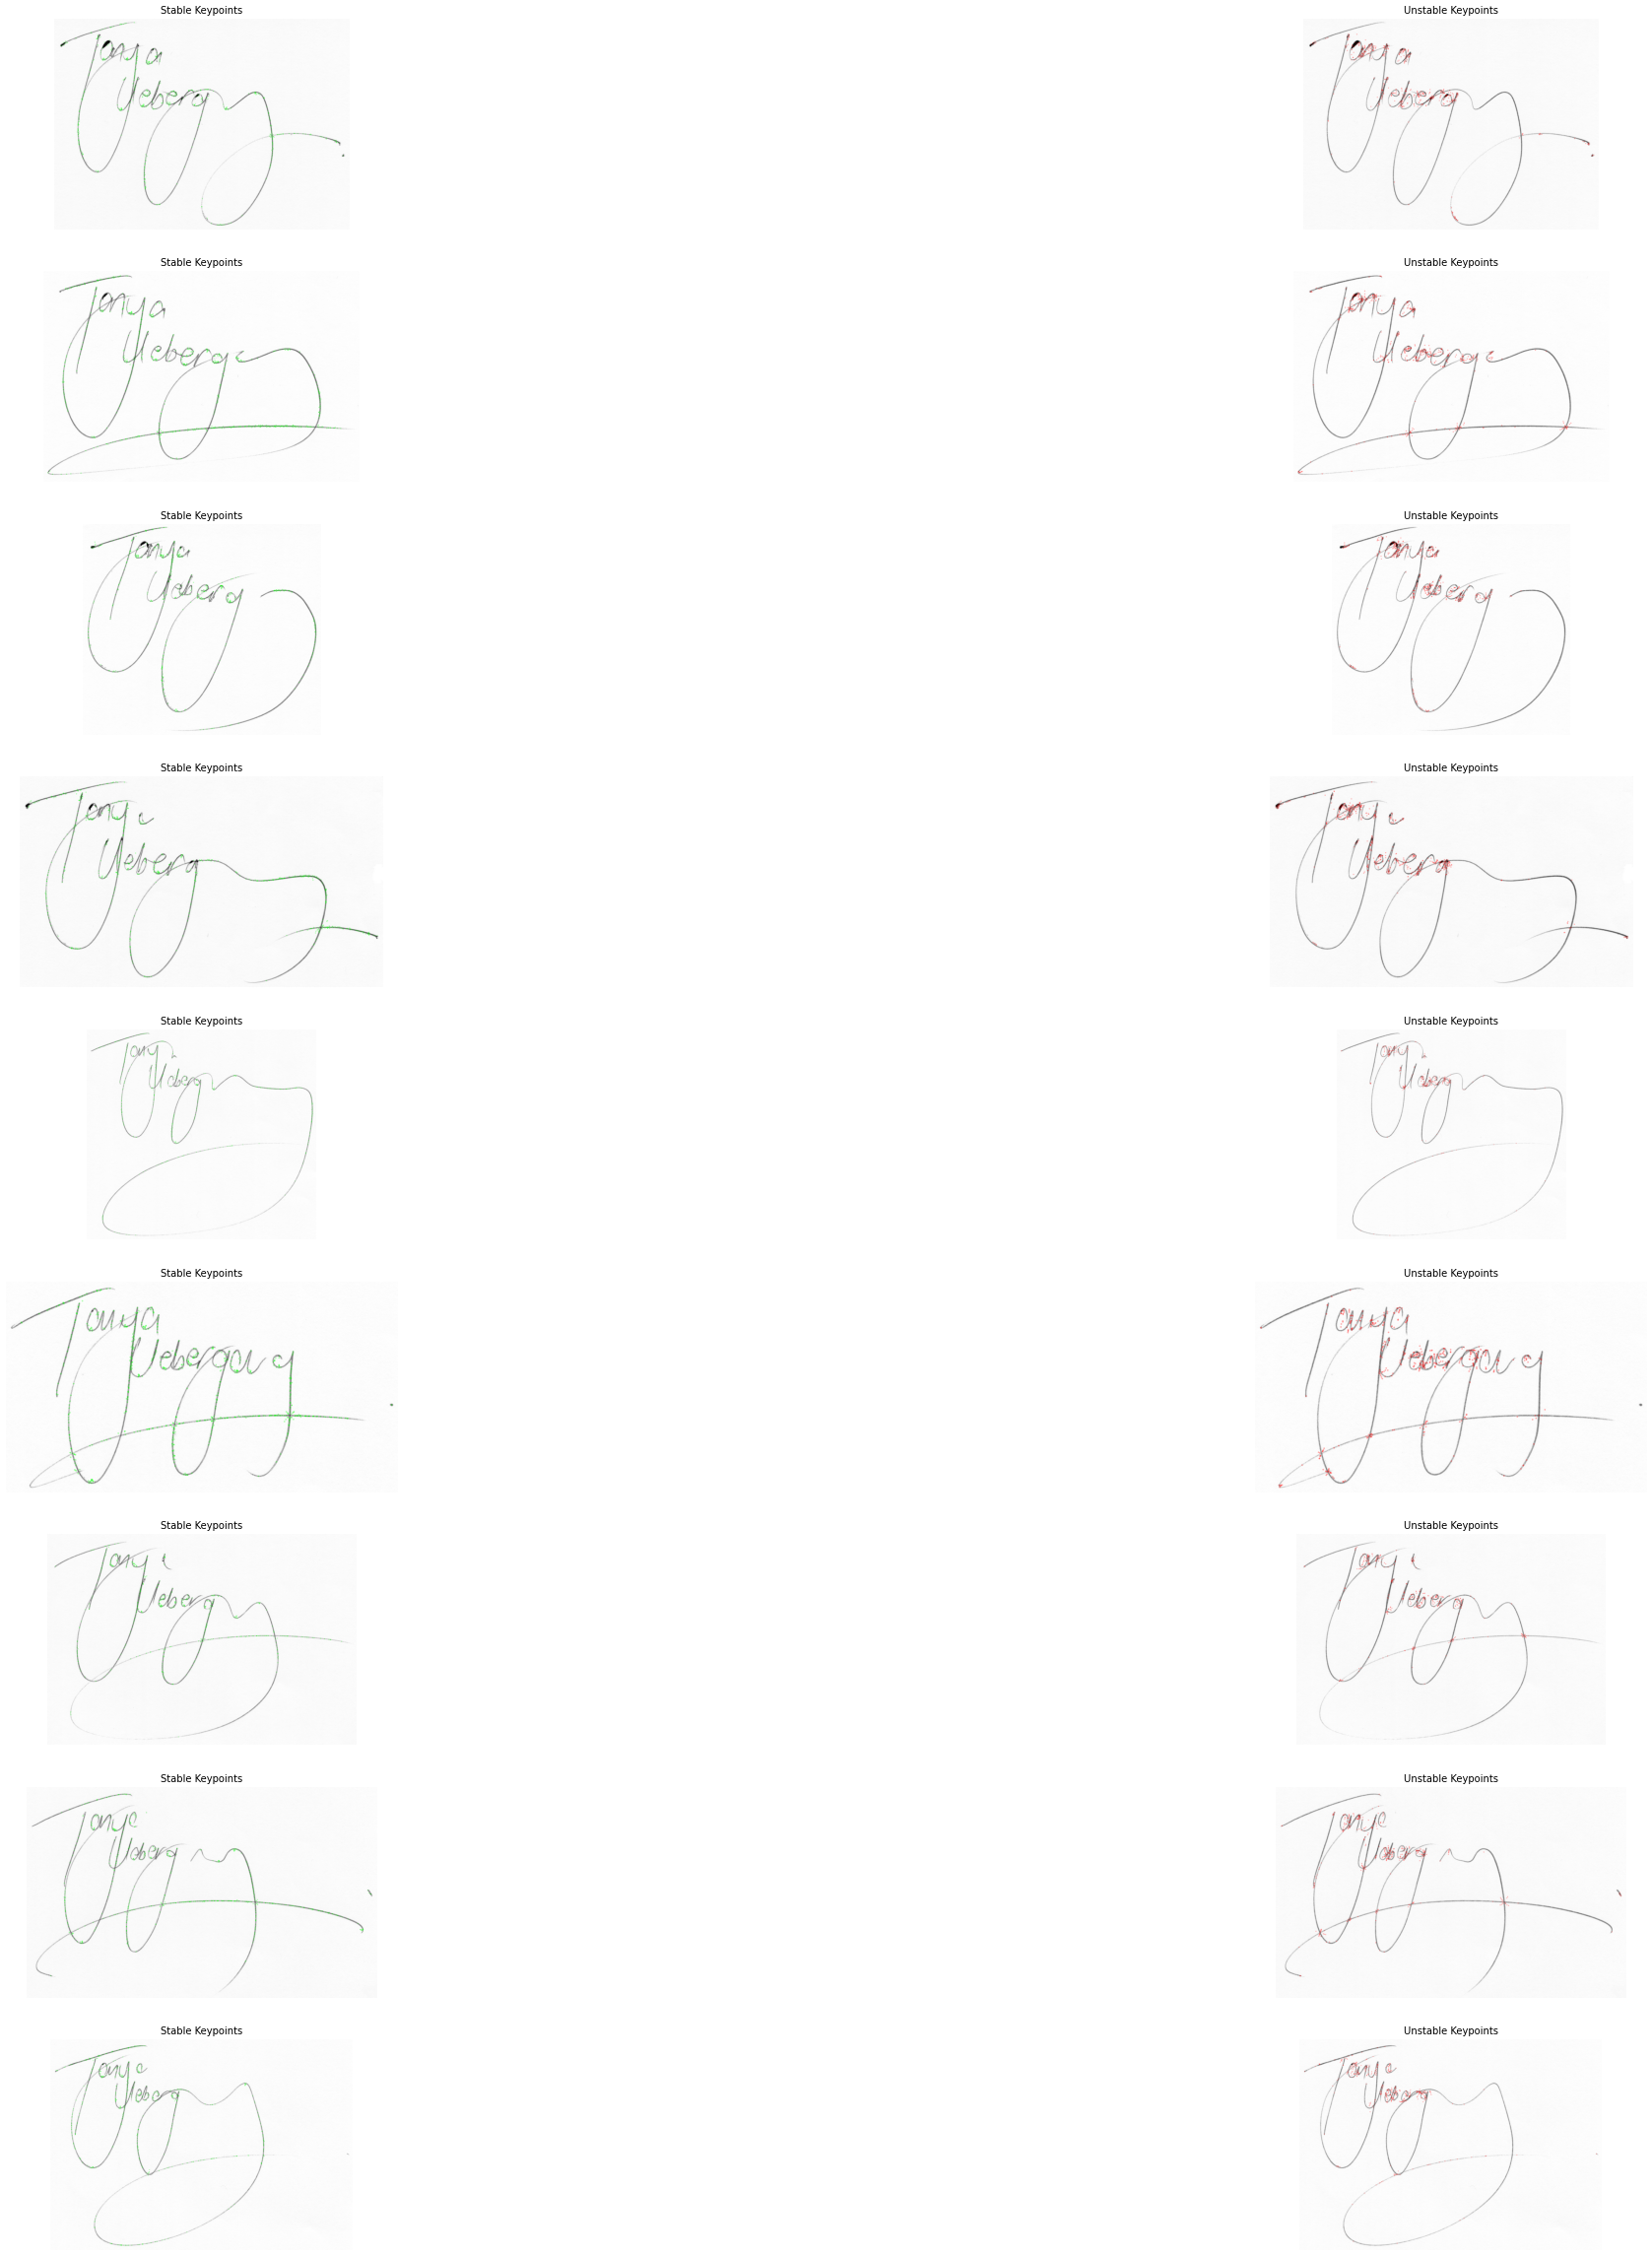

In [102]:
DB = Local_Stable_features(path_trainref,'surf')

['R001.png', 'R002.png', 'R003.png', 'R004.png', 'R005.png', 'R006.png', 'R007.png', 'R008.png', 'R009.png', 'R010.png', 'R011.png', 'R012.png', 'R013.png', 'R014.png', 'R015.png', 'R016.png', 'R017.png', 'R018.png', 'R019.png', 'R020.png', 'R021.png', 'R022.png', 'R023.png', 'R024.png', 'R025.png', '_Thumbs.db']


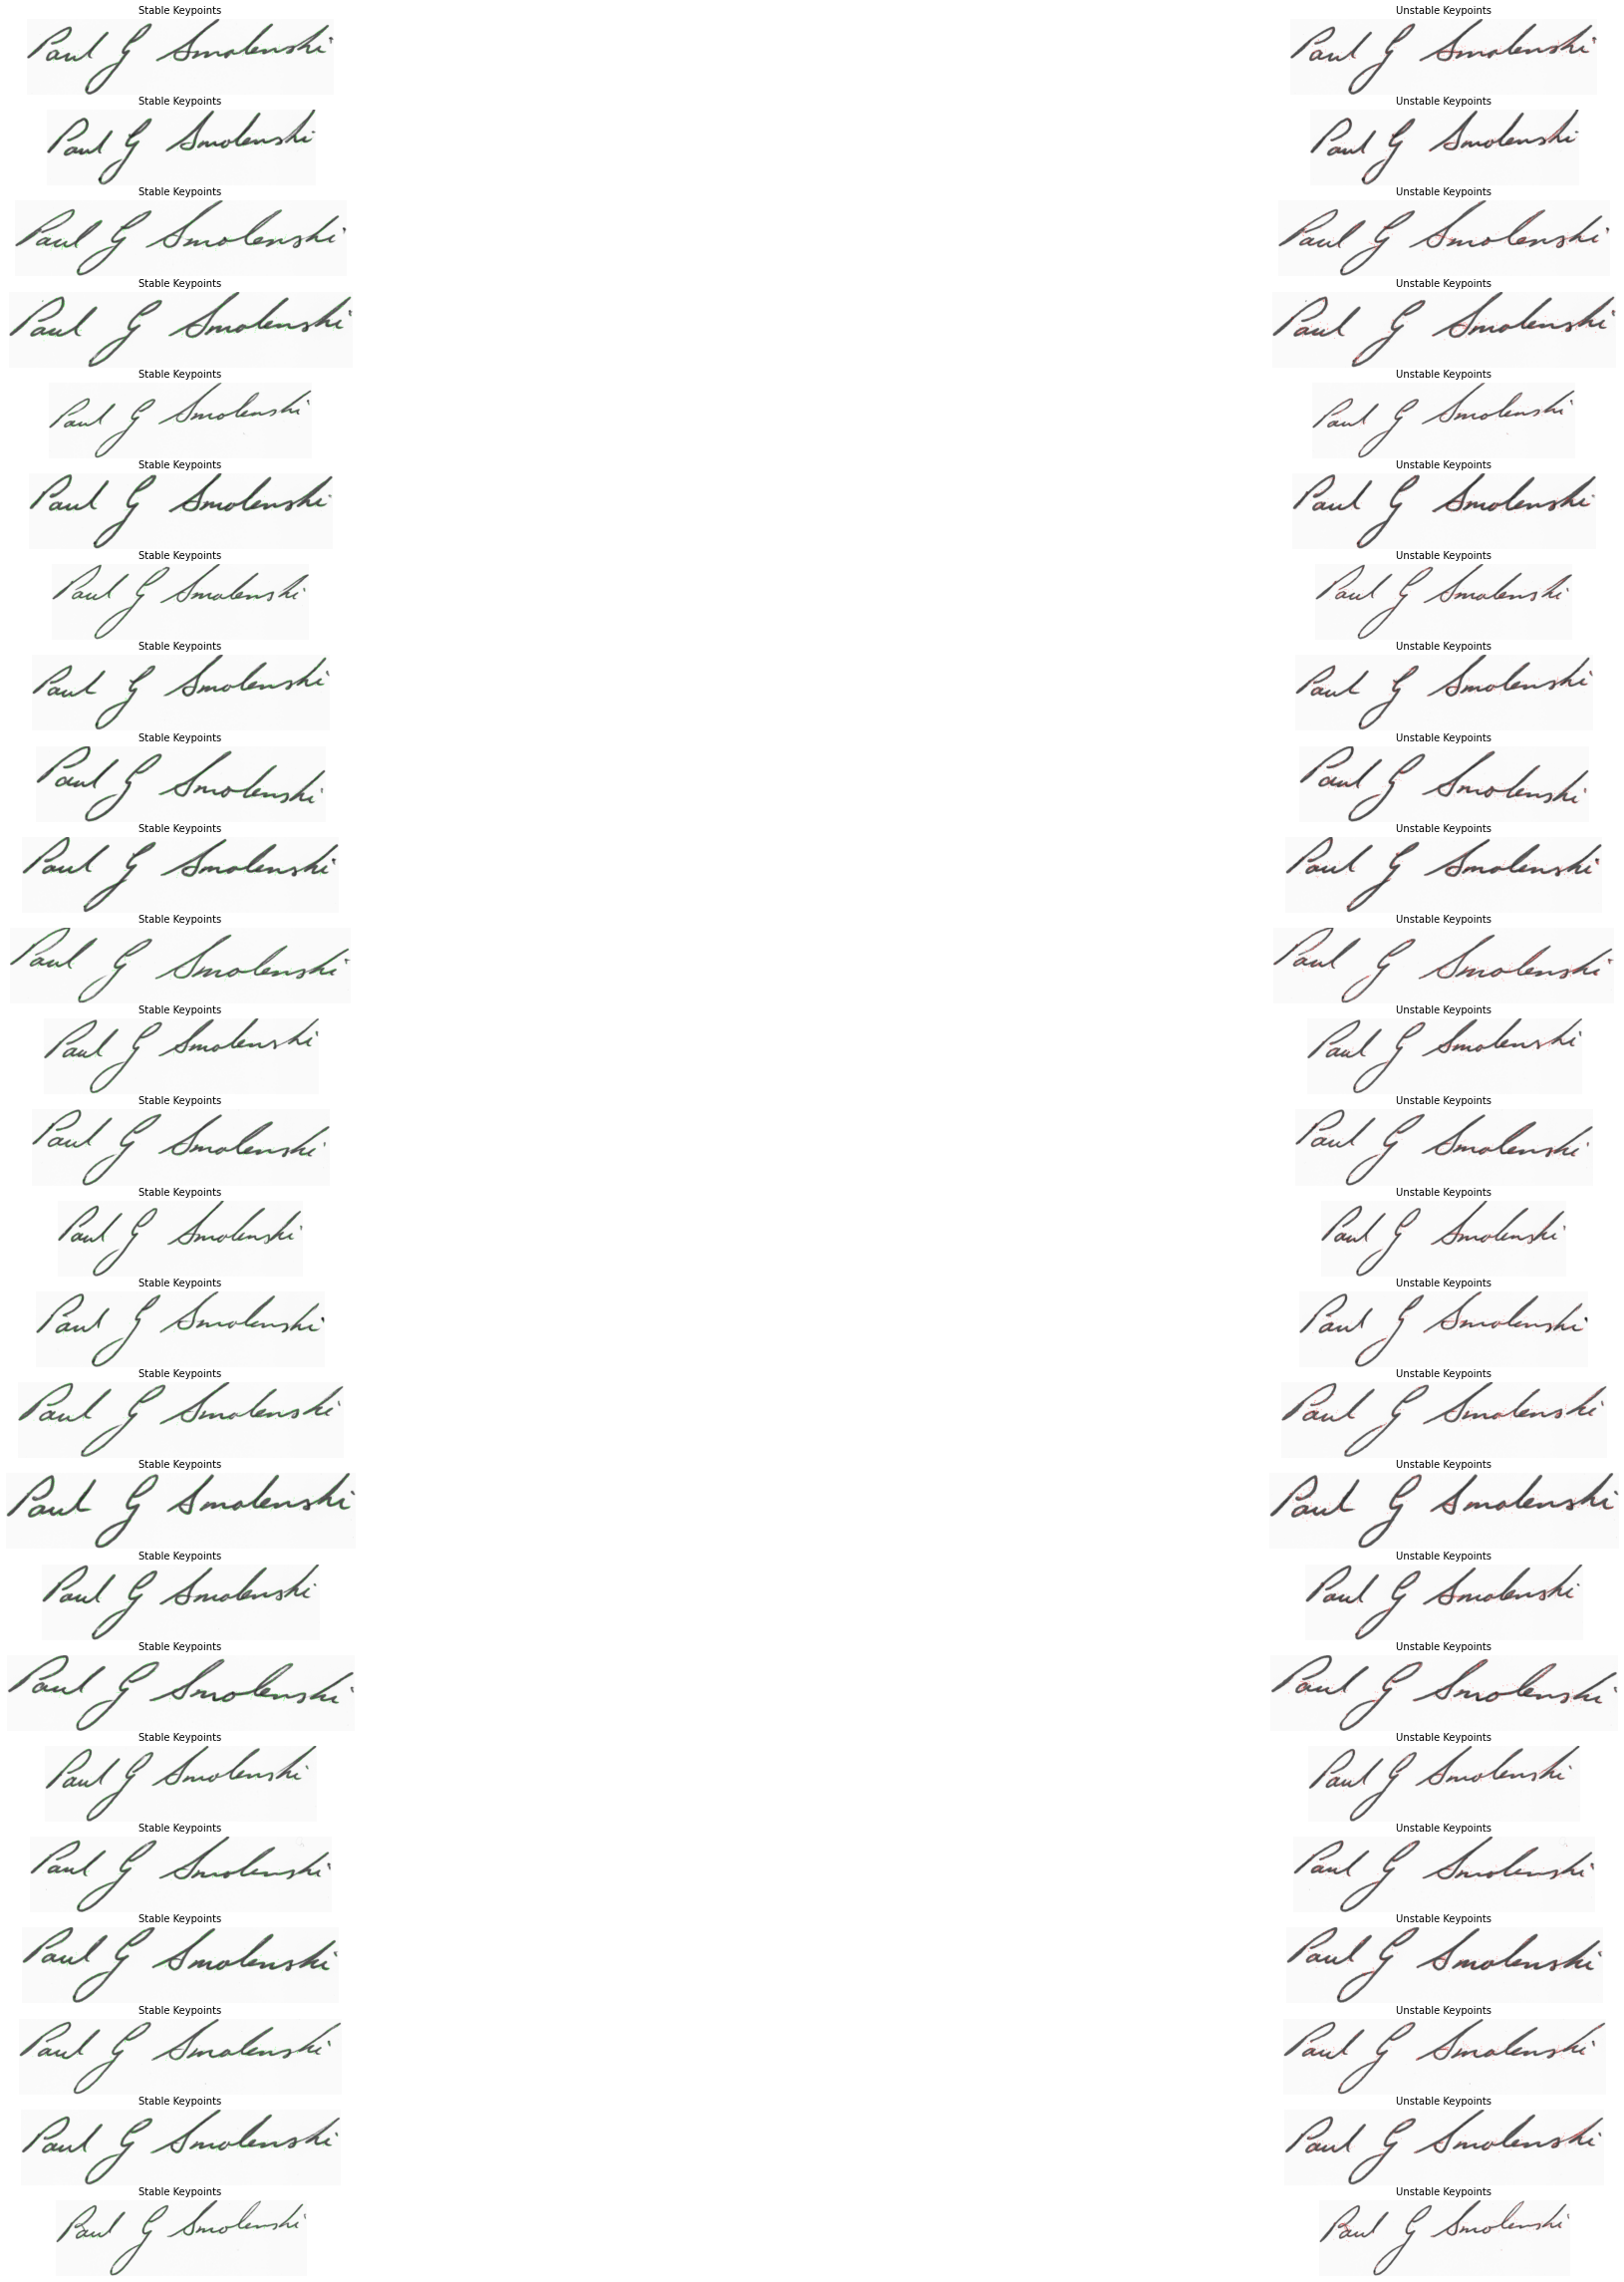

In [103]:
DB1 = Local_Stable_features(path_testref,'surf')

In [104]:
""" Plot Functions """
import matplotlib.pyplot as plt

def plot_matches(genuine_match, disguise_match, simulated_match, threshold):
    """ Plot Match Point percentages """

    plt.figure(figsize = (8, 8))
    match = [genuine_match, disguise_match, simulated_match]
    plt.hist(match, label=['Genuine', 'Disguise', 'Simulated'])
    plt.legend()
    plt.title('Matched Points')
    plt.savefig('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Plots/PMatchpoints' + str(threshold) + '.jpg')
    plt.show()

def plot_EER(theta_range, far, frr, threshold):
    """ Plot EER vs Theta """

    plt.figure(figsize = (8, 8))
    plt.plot(theta_range, far, color = 'red')
    plt.plot(theta_range, frr, color = 'blue')
    plt.title('EER vs Theta')
    plt.legend(['FAR', 'FRR'])
    plt.savefig('/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Plots/Error' + str(threshold) + '.jpg')
    plt.show()

In [105]:
def classify(img, DB, thresh,parameter):

  match_percent=0
  num_points_stable=0
  num_points_slightly_stable=0
  num_points_unstable=0
  kp_stable=[]
  kp_slightly_stable=[]
  kp_unstable=[]
  surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 1000, extended = 1)
  surf_info = surf.detectAndCompute(img, None)
  keypoints=surf_info[0]
  k=0
  for point in surf_info[1]:
    min=np.min(np.linalg.norm(DB-point,axis=1))
    #print("printing min")
    #print(min)
    if min <= thresh:
      num_points_stable +=1
      kp_stable.append(keypoints[k])
    else:
      if min <= 3*thresh:
        num_points_slightly_stable +=1
        kp_slightly_stable.append(keypoints[k])
      else:
        num_points_unstable +=1  
        kp_unstable.append(keypoints[k])
    k=k+1    
  #print("done")    
  if parameter==1:
    return num_points_stable/surf_info[1].shape[0]
  else:
    return kp_stable,kp_slightly_stable,kp_unstable
    

Validating Genuine Signatures
Validating Disguise Signatures
Validating Simulated Signatures


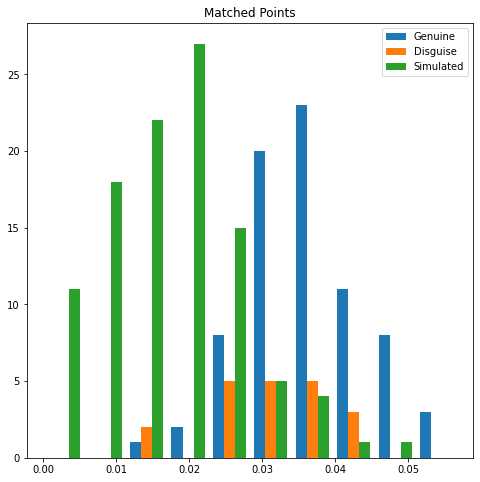

In [106]:
""" Generating Database and Graphs for Train set """

# User defined modules 



# Load/Save DB
DB=convert_to_pkl(DB,'/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/database.pkl')
threshold = 0.11


# Matched Points Percentage for each type of signature
print("Validating Genuine Signatures")
img = []
genuine_match=[]
disguise_match=[]
simulated_match=[]
file_names = os.listdir(path_traingen)
img=np.array([cv2.imread(path_traingen+me,0) for me in file_names if (me[len(me)-4:len(me)]==".png" or me[len(me)-4:len(me)]==".PNG" or me[len(me)-4:len(me)]==".jpeg")])
genuine_match=[classify(img[i],DB,threshold,1) for i in range(img.shape[0])]

print("Validating Disguise Signatures")
img1 = []
file_names1 = os.listdir(path_traindis)
img1=np.array([cv2.imread(path_traindis+me,0) for me in file_names1 if (me[len(me)-4:len(me)]==".png" or me[len(me)-4:len(me)]==".PNG" or me[len(me)-4:len(me)]==".jpeg")])
disguise_match=[classify(img1[i],DB,threshold,1) for i in range(img1.shape[0])]

print("Validating Simulated Signatures")
img2 = []
file_names2 = os.listdir(path_trainsim)
img2=np.array([cv2.imread(path_trainsim+me,0) for me in file_names2 if (me[len(me)-4:len(me)]==".png" or me[len(me)-4:len(me)]==".PNG" or me[len(me)-4:len(me)]==".jpeg")])
simulated_match=[classify(img2[i],DB,threshold,1) for i in range(img2.shape[0])]


# Save/Load percentages (for convenience)

genuine_match,disguise_match,simulated_match=convert_to_pkl([genuine_match,disguise_match,simulated_match],'/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/vals' +
                                            str(threshold) + '.pkl')
plot_matches(genuine_match, disguise_match, simulated_match, threshold)




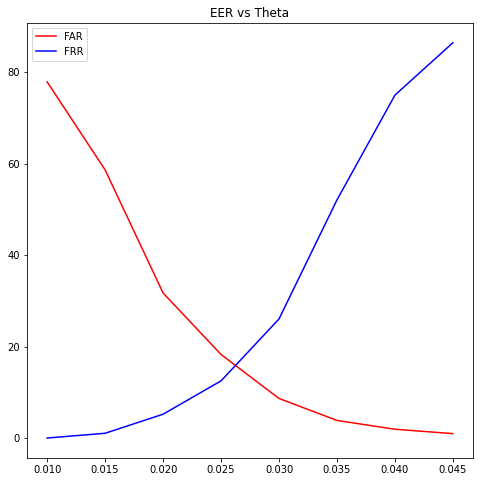

		Genuine	Fake
Genuine		68	8
Disguise	14	6
Simulated	12	92


In [107]:
# Calculate FAR and FRR
genuine_match=np.array(genuine_match)
simulated_match=np.array(simulated_match)
disguise_match=np.array(disguise_match)
far = []
frr = []
theta_range = np.arange(0.01, 0.05, 0.005)
for theta in theta_range:
    ind1 = np.where(genuine_match < theta)
    ind2 = np.where(disguise_match < theta)
    ind3 = np.where(simulated_match > theta)
    frr.append((len(ind1[0]) + len(ind2[0])) / (genuine_match.shape[0] + disguise_match.shape[0]) * 100)
    far.append(len(ind3[0]) / simulated_match.shape[0] * 100)
plot_EER(theta_range, far, frr, threshold)


# Compute Confidence Matrix
eer = 0.0275
ind = np.where(genuine_match < eer)
ind1 = np.where(disguise_match < eer)
ind2 = np.where(simulated_match > eer)
print('\t\tGenuine\tFake')
print('Genuine\t\t' + str(genuine_match.shape[0] - ind[0].shape[0]) + '\t' + str(ind[0].shape[0]))
print('Disguise\t' + str(disguise_match.shape[0] - ind1[0].shape[0]) + '\t' + str(ind1[0].shape[0]))
print('Simulated\t' + str(ind2[0].shape[0]) + '\t' + str(simulated_match.shape[0] - ind2[0].shape[0]))

In [110]:


# Load/Save DB

#storeData(DB1, '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/database_test.pkl')
DB1 = convert_to_pkl(DB1,'/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/database_test.pkl')
threshold = 0.11


# Matched Points Percentage for each type of signature

print("Validating query Signatures")
image = []
query_match=[]
names = os.listdir(path_testque)
names=sorted(names)
genuine=[]
disguise=[]
simulated=[]
genuine_match=[]
disguise_match=[]
simulated_match=[]
for img_name in names:
  length = len(img_name)
  if img_name[2:4] in ["49", "52", "66"] and img_name[length - 4: length] == ".png":
    genuine.append(cv2.imread(path_testque + img_name, 0))
  elif img_name[2:4] in ["06", "15", "28", "29", "34", "87", "90"] and img_name[length - 4: length] == ".png":
      disguise.append(cv2.imread(path_testque + img_name, 0))
  else:
    if img_name[length - 4: length] == ".png":
      simulated.append((cv2.imread(path_testque + img_name, 0)))
genuine = np.array(genuine)
simulated=np.array(simulated)
disguise=np.array(disguise)
print(disguise.shape[0])
print(genuine.shape[0])
print(simulated.shape[0])


Validating query Signatures
7
3
90


In [111]:
for i in range(genuine.shape[0]):
  genuine_match.append(classify(genuine[i], DB1, threshold,1))
for i in range(disguise.shape[0]):
  disguise_match.append(classify(disguise[i], DB1, threshold,1))
for i in range(simulated.shape[0]):
  simulated_match.append(classify(simulated[i], DB1, threshold,1))    
genuine_match=np.array(genuine_match)
disguise_match=np.array(disguise_match)
simulated_match=np.array(simulated_match)

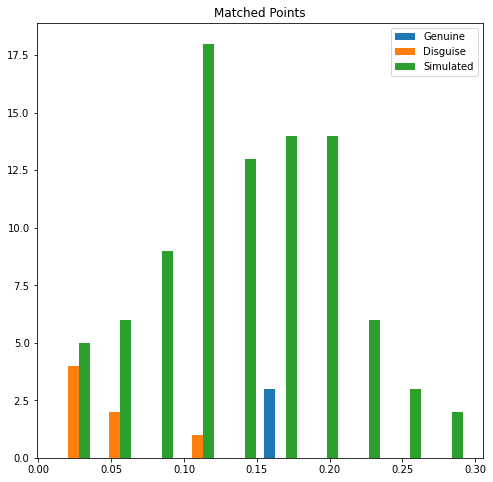

In [112]:
#print(disguise_match)
#print(genuine_match)
#print(simulated_match)
# Save/Load percentages (for convenience)
genuine_match, disguise_match, simulated_match = convert_to_pkl([genuine_match, disguise_match, simulated_match],'/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Pickles/vals_test' +
                                          str(threshold) + '.pkl')
plot_matches(genuine_match, disguise_match, simulated_match, threshold)

60.0
60.0
60.0
60.0
60.0


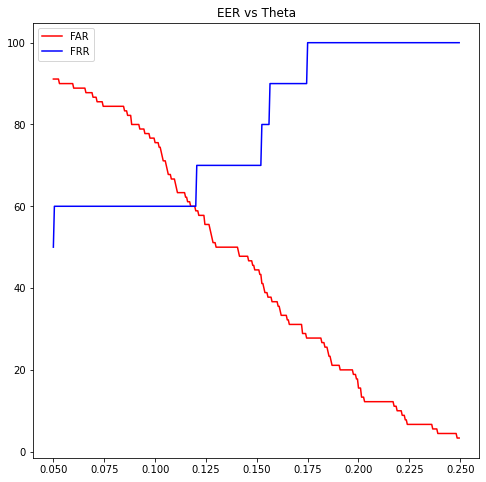

0.15
		Genuine	Fake
Genuine		3	0
Disguise	0	7
Simulated	40	50


In [113]:
far = []
frr = []
theta_range = np.arange(0.05, 0.25, 0.0005)
temp=0
eer=0
for theta in theta_range:
    ind1 = np.where(genuine_match < theta)
    ind2 = np.where(disguise_match < theta)
    ind3 = np.where(simulated_match > theta)
    frr.append((ind1[0].shape[0] + ind2[0].shape[0]) / (genuine_match.shape[0] + disguise_match.shape[0]) * 100)
    far.append(ind3[0].shape[0] / simulated_match.shape[0] * 100)
    if(far[temp]==frr[temp]):
      print(frr[temp])
    temp+=1
plot_EER(theta_range, far, frr, threshold)
eer=0.125
# Compute Confidence Matrix
print(eer)
ind = np.where(genuine_match < eer)
ind1 = np.where(disguise_match < eer)
ind2 = np.where(simulated_match > eer)
print('\t\tGenuine\tFake')
print('Genuine\t\t' + str(genuine_match.shape[0] - ind[0].shape[0]) + '\t' + str(ind[0].shape[0]))
print('Disguise\t' + str(disguise_match.shape[0] - ind1[0].shape[0]) + '\t' + str(ind1[0].shape[0]))
print('Simulated\t' + str(ind2[0].shape[0]) + '\t' + str(simulated_match.shape[0] - ind2[0].shape[0]))

['WhatsApp Image 2020-11-17 at 18.23.14.jpeg', 'WhatsApp Image 2020-11-17 at 18.23.15.jpeg', 'WhatsApp Image 2020-11-17 at 18.23.17.jpeg', 'WhatsApp Image 2020-11-17 at 18.23.18.jpeg']


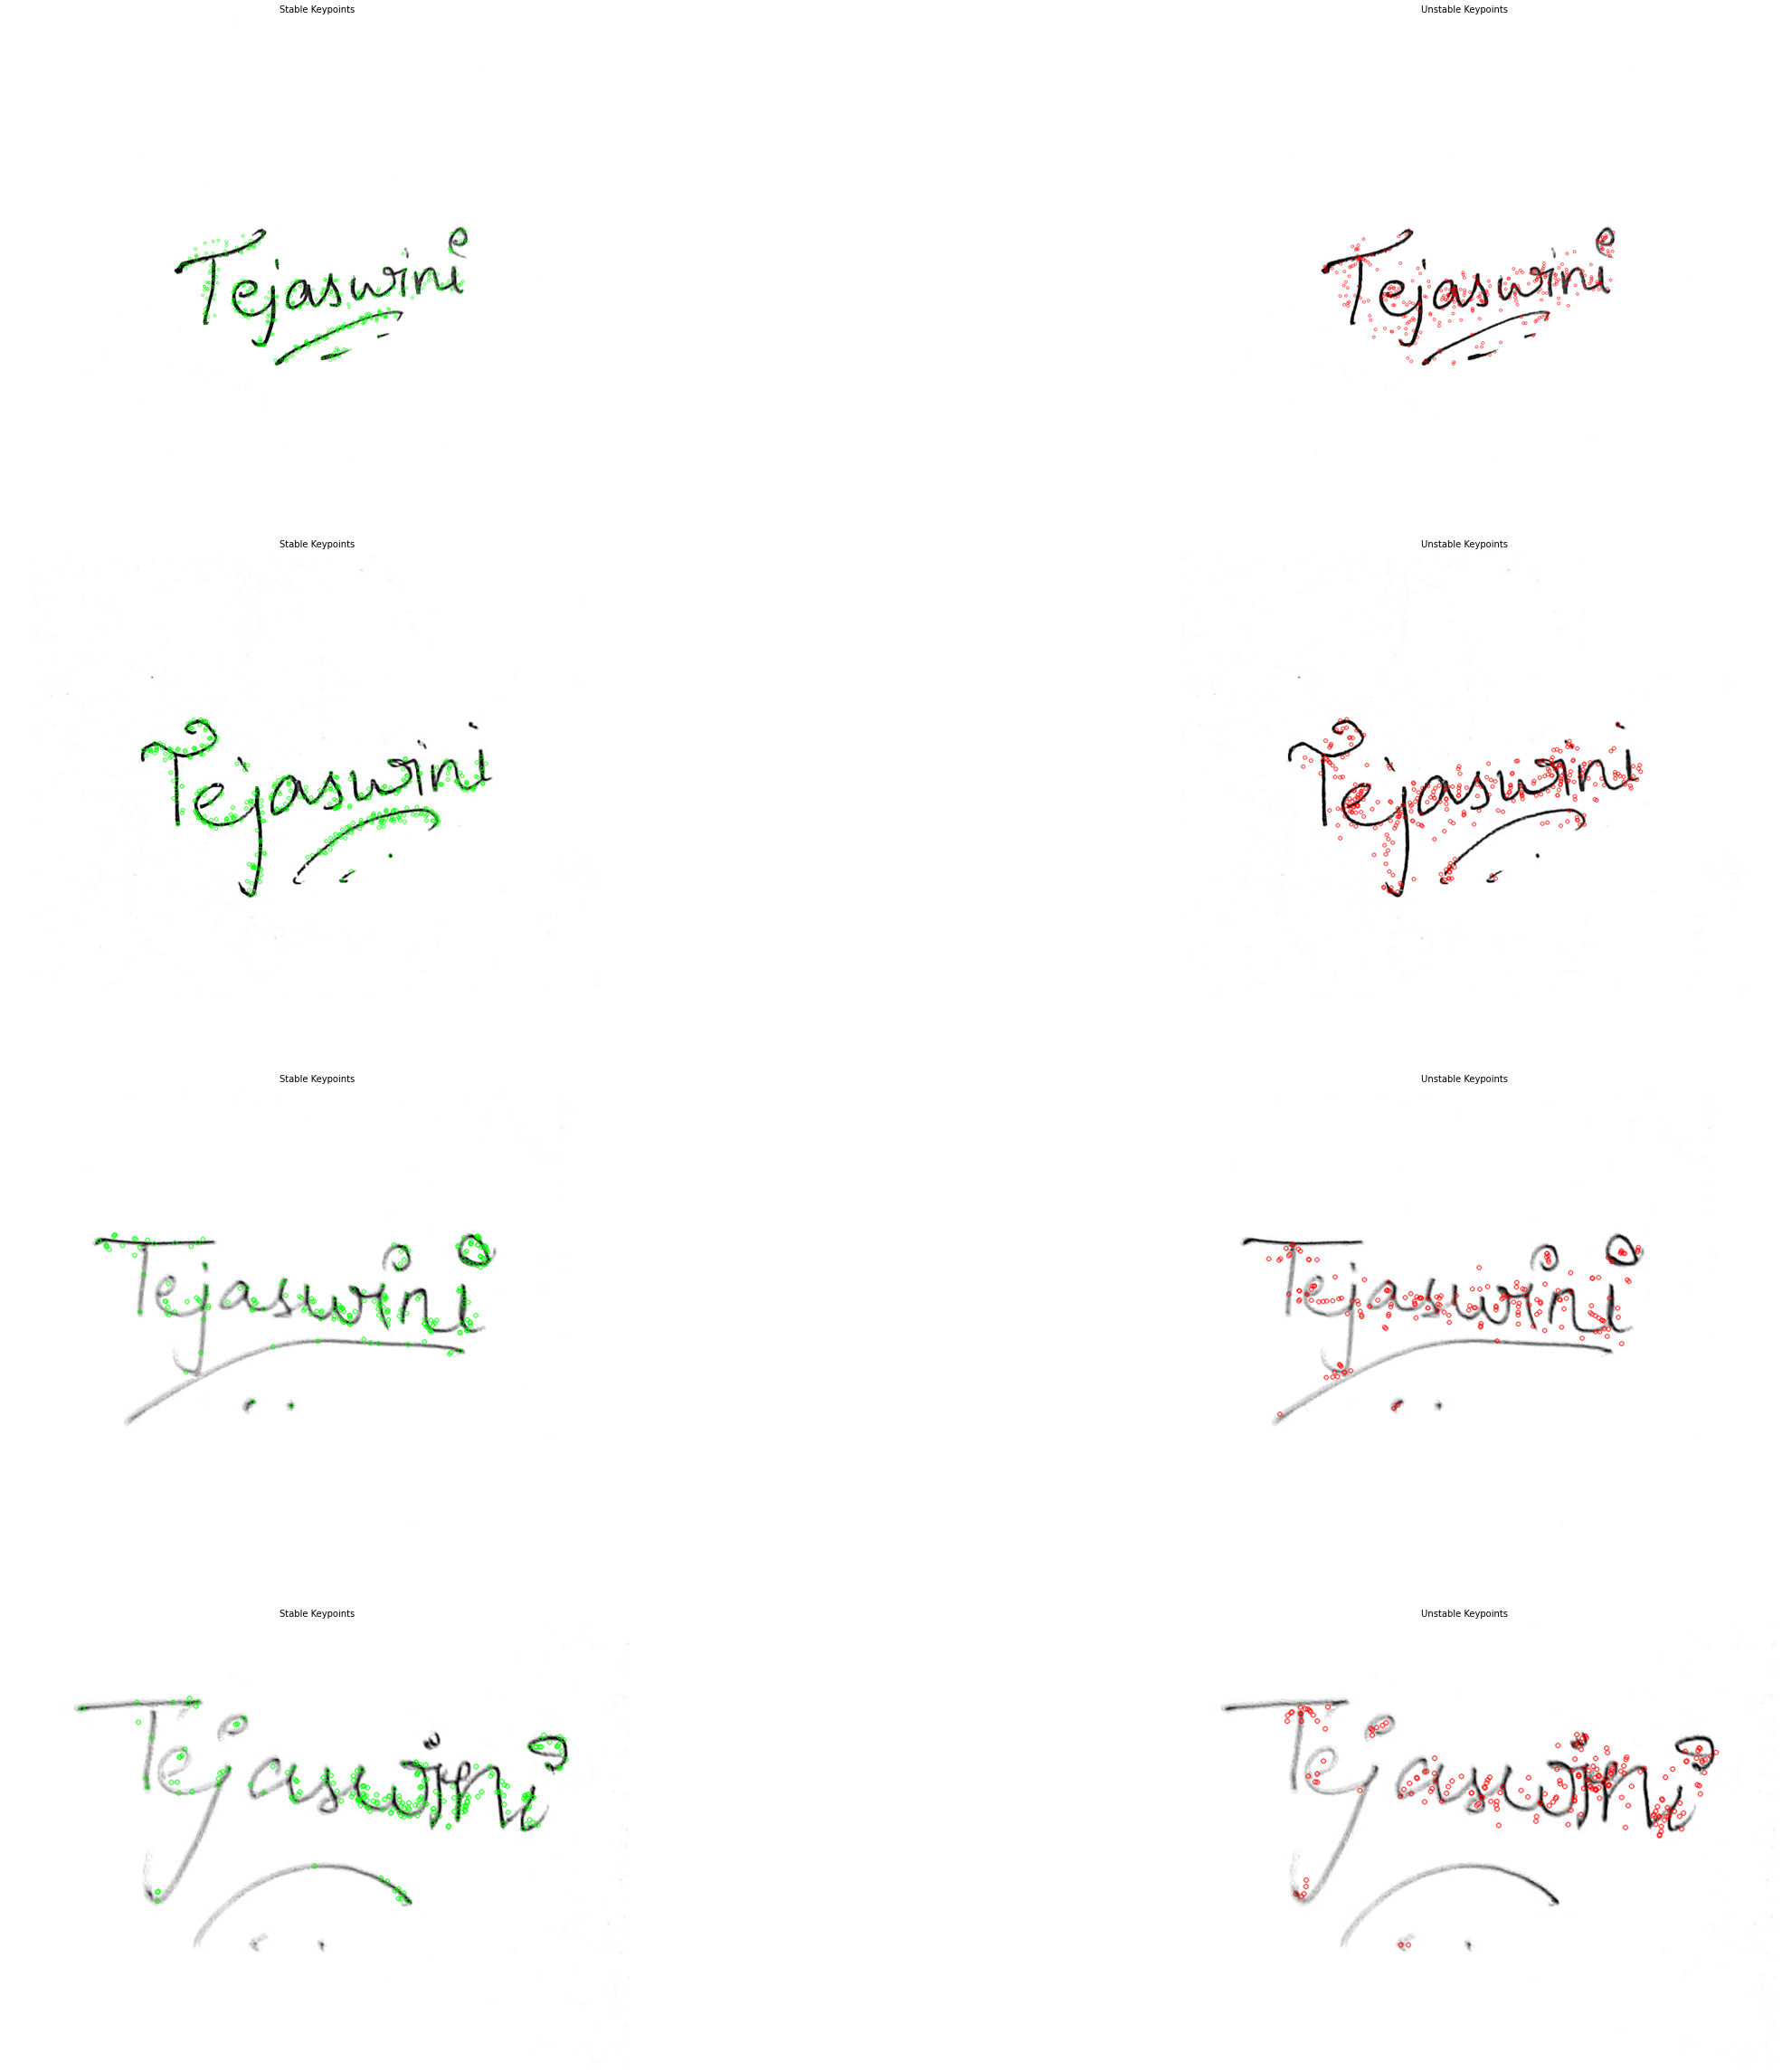

In [114]:
dr_path = '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/'
gen = '/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Verify/Genuine/'
disg ='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Verify/Disguise/'
fak ='/content/drive/My Drive/Digital Image processing/Automatic-Signature-Stability-Analysis-And-Verification-Using-Local-Features/Verify/fake/'
DB = Local_Stable_features(dr_path+'Verify/Reference/','surf')
#storeData(DB, dr_path+'Pickles/database.pkl')
DB = convert_to_pkl(DB,dr_path+'Pickles/database.pkl')

Validating Genuine Signatures

Validating Disguise Signatures

Validating Simulated Signatures



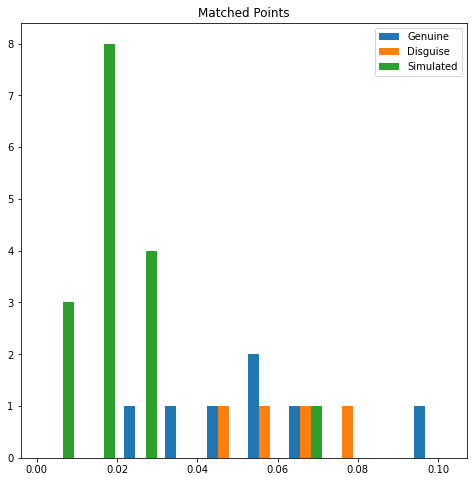

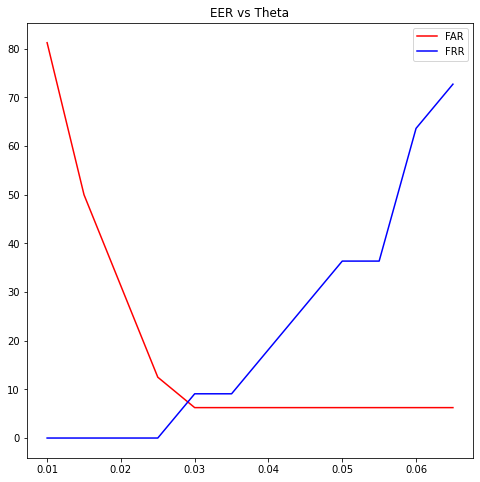

		Genuine	Fake
Genuine		7	0
Disguise	4	0
Simulated	3	13


In [116]:
# Matched Points Percentage for each type of signature
threshold = 0.17
print("Validating Genuine Signatures\n")
img = []
genuine_match=[]
disguise_match=[]
simulated_match=[]
file_names = os.listdir(gen)
for img_name in file_names:
  img.append(cv2.imread(gen + img_name,0))
img = np.array(img)
for i in range(img.shape[0]):
  genuine_match.append(classify(img[i], DB, threshold,1))


print("Validating Disguise Signatures\n")
img1 = []
file_names1 = os.listdir(disg)
for img_name in file_names1:
    img1.append(cv2.imread(disg + img_name,0))
img1 = np.array(img1)
for i in range(img1.shape[0]):
  disguise_match.append(classify(img1[i], DB, threshold,1))

print("Validating Simulated Signatures\n")
img2 = []
file_names2 = os.listdir(fak)
for img_name in file_names2:
    img2.append(cv2.imread(fak + img_name, 0))
img2 = np.array(img2)
for i in range(img2.shape[0]):
  simulated_match.append(classify(img2[i], DB, threshold,1))


# Save/Load percentages (for convenience)
#storeData([genuine_match, disguise_match, simulated_match], dr_path+'Pickles/vals' + str(threshold) + '.pkl')
genuine_match, disguise_match, simulated_match = convert_to_pkl([genuine_match, disguise_match, simulated_match],dr_path+'Pickles/vals' + str(threshold) + '.pkl')

plot_matches(genuine_match, disguise_match, simulated_match, threshold)
genuine_match=np.array(genuine_match)
simulated_match=np.array(simulated_match)
disguise_match=np.array(disguise_match)

# Calculate FAR and FRR
far = []
frr = []
theta_range = np.arange(0.01, 0.07, 0.005)
for theta in theta_range:
    ind1 = np.where(genuine_match < theta)
    ind2 = np.where(disguise_match < theta)
    ind3 = np.where(simulated_match > theta)
    frr.append((ind1[0].shape[0] + ind2[0].shape[0]) / (genuine_match.shape[0] + disguise_match.shape[0]) * 100)
    far.append(ind3[0].shape[0] / simulated_match.shape[0] * 100)
plot_EER(theta_range, far, frr, threshold)


# Compute Confidence Matrix
eer = 0.025
ind = np.where(genuine_match < eer)
ind1 = np.where(disguise_match < eer)
ind2 = np.where(simulated_match > eer)
print('\t\tGenuine\tFake')
print('Genuine\t\t' + str(genuine_match.shape[0] - ind[0].shape[0]) + '\t' + str(ind[0].shape[0]))
print('Disguise\t' + str(disguise_match.shape[0] - ind1[0].shape[0]) + '\t' + str(ind1[0].shape[0]))
print('Simulated\t' + str(ind2[0].shape[0]) + '\t' + str(simulated_match.shape[0] - ind2[0].shape[0]))